In [9]:
import cv2
import os
import pandas as pd
import math as m
import mediapipe as mp
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
import pickle
from main_functions import euc_distance, create_features_dict

# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [10]:
face_data = {'teta1':0,'teta2':0,'teta3': 0,'teta4': 0,'teta5': 0,'teta6': 0,'teta7': 0,
'teta8': 0,'teta9': 0,'teta10': 0}
faces = pd.DataFrame(face_data,index=[0])

In [11]:
# Face points
P = { 0: 61, 1: 292, 2: 0, 3: 17, 4:	50,	5: 280,	6: 48, 7: 4, 8:	289, 9:	206, 10: 426, 11: 133, 12: 130, 13: 159,\
14:	145, 15: 362, 16: 359, 17: 386, 18:	374, 19: 122, 20: 351, 21: 46, 22: 105, 23: 107, 24: 276, 25: 334, 26: 336 }
points = [i for i in range (469)]
# points_dict = {i : 0 for i in range(469)}

# Angles are calculated between vectors formed by points in P.
# After --> initial MediaPipe points and descriptions are also given 
# (Left and right sides defined according to face_annotated.jpg. Faces in real-time video may be flipped). 
# Angles between different parts of face (e.g. between nose and mouth sides) are defined as 'Neutral' 
# θ1	(2, 0, 3) --> (0, 61, 17) Left lips
# θ2	(0, 2, 1) --> (61, 0, 386) Neutral mouth
# θ3	(6, 7, 8) --> (48, 4, 289) Neutral nose
# θ4	(9, 7, 10) --> (206, 4, 426) Neutral mouth sides - nose
# θ5	(0, 7, 1) --> (61, 4, 292) Neutral lower cheeks - nose
# θ6	(1, 5, 8) --> (292, 280, 289) Right cheek upper
# θ7	(1, 10, 8) --> (292, 426, 289) Right cheek lower
# θ8	(13, 12, 14) --> (159, 130, 145) Left eye outer
# θ9	(21, 22, 23) --> (46, 105, 107) Left eyebrow
# θ10	(6, 19, 23) --> (48, 122, 107) Left eyebrow - nose

In [12]:
# MediaPipe Mesh detection parameters
face_mesh = mp_face_mesh.FaceMesh(
  max_num_faces=50,
  refine_landmarks= True,
  min_detection_confidence=0.3,
  min_tracking_confidence=0.05)

In [13]:
def create_features_dict_full(image_path, points, P, face_mesh, faces):
    images = os.listdir(image_path)
    faces = pd.DataFrame(face_data,index=[0])
    s=0
    for idx, file in enumerate(images):
        image = cv2.imread(image_path+'/'+file)
        df = create_features_dict(image, points, P, face_mesh, s)
        faces_data_frame = pd.DataFrame(df,index=[s])
        faces_data_frame['path'] = image_path+'/'+file
        faces = pd.concat([faces, faces_data_frame])
        s+=1
    return faces

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:
faces_angry = create_features_dict_full('train/Anger', points, P, face_mesh, faces).copy()
faces_angry = faces_angry.drop(faces_angry[faces_angry['teta1']==0].index)

In [15]:
faces_neutral=create_features_dict_full('train/neutral', points, P, face_mesh, faces).copy()
faces_neutral = faces_neutral.drop(faces_neutral[faces_neutral['teta1']==0].index)

In [16]:
faces_happy=create_features_dict_full('train/Happy', points, P, face_mesh, faces).copy()
faces_happy = faces_happy.drop(faces_happy[faces_happy['teta1']==0].index)

In [17]:
faces_sad=create_features_dict_full('train/Sad', points, P, face_mesh, faces).copy()
faces_sad = faces_sad.drop(faces_sad[faces_sad['teta1']==0].index)

In [18]:
faces_fear=create_features_dict_full('train/Fear', points, P, face_mesh, faces).copy()
faces_fear = faces_fear.drop(faces_fear[faces_fear['teta1']==0].index)

In [19]:
faces_disgust=create_features_dict_full('train/disgust', points, P, face_mesh, faces).copy()
faces_disgust = faces_disgust.drop(faces_disgust[faces_disgust['teta1']==0].index)

In [20]:
faces_surprise=create_features_dict_full('train/Surprise', points, P, face_mesh, faces).copy()
faces_surprise = faces_surprise.drop(faces_surprise[faces_surprise['teta1']==0].index)

In [21]:
faces_sad['target']='sad'
faces_happy['target']='happy'
faces_angry['target']='angry'
faces_neutral['target']='neutral'
faces_surprise['target']='surprise'
faces_fear['target']='fear'
faces_disgust['target']='disgust'

In [22]:
df_1 = pd.concat([faces_neutral, faces_sad, faces_happy, faces_surprise]).reset_index()

In [23]:
## Check NaN values in overall dataframe
def display_missing(df):
    for col in df.columns.tolist():
        print('{} Количество пропущенных значений: {}'.format(col, df[col].isnull().sum()))
    print('\n')

display_missing(df_1)

index Количество пропущенных значений: 0
teta1 Количество пропущенных значений: 0
teta2 Количество пропущенных значений: 0
teta3 Количество пропущенных значений: 0
teta4 Количество пропущенных значений: 0
teta5 Количество пропущенных значений: 0
teta6 Количество пропущенных значений: 0
teta7 Количество пропущенных значений: 0
teta8 Количество пропущенных значений: 0
teta9 Количество пропущенных значений: 0
teta10 Количество пропущенных значений: 0
l_eye_w Количество пропущенных значений: 0
l_eye_h Количество пропущенных значений: 0
r_eye_w Количество пропущенных значений: 0
r_eye_h Количество пропущенных значений: 0
lips_w Количество пропущенных значений: 0
lips_h Количество пропущенных значений: 0
lips_h_in Количество пропущенных значений: 0
brows_dist Количество пропущенных значений: 0
r_cheek_eye Количество пропущенных значений: 0
l_cheek_eye Количество пропущенных значений: 0
r_cheek_lip Количество пропущенных значений: 0
l_cheek_lip Количество пропущенных значений: 0
r_eye_brow_in

In [24]:
pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(df_1.drop(['index','path', 'target'], axis=1))

In [25]:
# Train test split with PCA
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(x_train_pca, df_1['target'],\
                                                        random_state=555, test_size=0.2, shuffle = True)

In [26]:
# Train test split without PCA
x_train, x_valid, y_train, y_valid = train_test_split(df_1.drop(['index'], axis=1), df_1['target'],\
                                                      random_state=666, test_size=0.2, shuffle = True)

In [27]:
cl_emo_1 = KNeighborsClassifier()
params = {
    'n_neighbors': [1, 3, 5, 7, 10, 20, 30, 40, 50],
    'weights': ['uniform', 'distance'],
}   
cv = GridSearchCV(cl_emo_1, param_grid=params, scoring='accuracy', cv=5, 
                  n_jobs=4)

In [6]:
# ## Train without PCA
# cv.fit(x_train.drop(['path'], axis=1), y_train)
# # filename = 'cl_emo_knn.sav'
# # pickle.dump(cv.best_estimator_, open(filename, 'wb'))
# cv.best_score_, cv.best_params_

In [7]:
# ## Train with PCA
# cv.fit(x_train.drop(['path'], axis=1), y_train)
# # filename = 'cl_emo_knn.sav'
# # pickle.dump(cv.best_estimator_, open(filename, 'wb'))
# cv.best_score_, cv.best_params_

In [28]:
cl_emo_2 = RandomForestClassifier()
from sklearn.model_selection import train_test_split
params = {
    'n_estimators': [10, 50, 100, 300, 500, 700, 1000],
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'max_depth' : [20, 50, 100],
    'min_samples_leaf': [3, 5, 7, 10, 20]
}

In [ ]:
# cv = GridSearchCV(cl_emo_2, param_grid=params, scoring='accuracy', cv=5, n_jobs=4)
# cv.fit(x_train, y_train)
# filename = 'cl_emo_logreg.sav'
# pickle.dump(cv.best_estimator_, open(filename, 'wb'))
# cv.best_score_, cv.best_params_

In [29]:
x_train.head()

,teta1,teta2,teta3,teta4,teta5,teta6,teta7,teta8,teta9,teta10,...,r_cheek_lip,l_cheek_lip,r_eye_brow_in,l_eye_brow_in,r_eye_brow_out,l_eye_brow_out,r_eye_nose_in,l_eye_nose_in,path,target
2273,47.561106,150.729369,147.370458,141.287883,93.046520,49.219286,102.640512,22.126438,132.574171,134.166169,...,0.221367,0.221829,0.112937,0.115146,0.119112,0.126610,0.134743,0.129195,train/Happy/happy540.jpg,happy
1299,26.405606,152.452583,142.850248,139.447652,75.483591,35.701046,75.706644,21.389617,145.106552,114.802967,...,0.302002,0.246847,0.108276,0.124418,0.117698,0.121965,0.135025,0.122763,train/Sad/sad501.jpg,sad
3242,20.131244,164.172841,149.954140,141.806126,81.491058,48.364981,95.928962,26.195510,138.372673,123.396040,...,0.223878,0.289987,0.121030,0.107755,0.112411,0.127212,0.121119,0.165196,train/Surprise/surprise230.jpg,surprise
331,39.955023,154.522313,120.454408,117.783276,62.797941,32.258098,83.602745,56.104074,119.982094,153.093564,...,0.233871,0.178831,0.093527,0.086774,0.093752,0.099403,0.096183,0.082813,train/neutral/neutral105.jpg,neutral
162,69.017317,144.700293,130.236849,115.695980,35.194044,36.993170,104.366443,70.662090,117.570586,156.080287,...,0.241126,0.230093,0.093236,0.070803,0.094611,0.099041,0.147541,0.110860,train/neutral/neutral639.jpg,neutral


In [31]:
cb1 = CatBoostClassifier(iterations=10000, random_strength = 10, 
l2_leaf_reg = 100, learning_rate = 0.01, min_data_in_leaf = 30, eval_metric= 'TotalF1', one_hot_max_size = 20, depth = 10, rsm = .6,
                        bagging_temperature = 10)
cb1.fit(x_train.drop(['path', 'target'], axis=1), y_train, verbose=0, plot=True, eval_set=(x_valid.drop(['path', 'target'], axis=1), y_valid), )
# filename = 'cl_emo_cb.sav'
# pickle.dump(cb1, open(filename, 'wb'))
y_pred_valid = cb1.predict(x_valid.drop(['path', 'target'], axis=1))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
# Test accuracy
(y_pred_valid.ravel() == y_valid.to_numpy()).sum() / len(y_valid)

0.8058124174372523

*** RESULTS ANALYSIS ***

In [28]:
# import shap
# explainer = shap.TreeExplainer(cb1)
# shap_values=explainer.shap_values(x_train)
# shap.summary_plot(shap_values,x_train)

: 

: 

In [156]:
# x_valid['pred'] = cb1.predict(x_valid.drop(['path','target'], axis=1))
# check_matrix = x_valid.copy()
# check_matrix['target'] = y_valid

Populating the interactive namespace from numpy and matplotlib


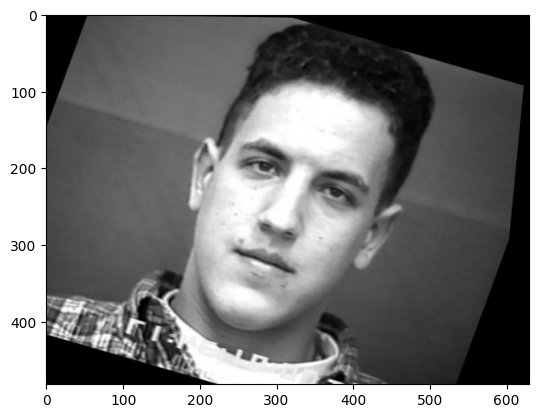

In [160]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('train/neutral/neutral565.jpg')
imgplot = plt.imshow(img)
plt.show()

In [5]:
# cb1.feature_importances_

In [4]:
# check_matrix[(check_matrix['pred'] != check_matrix['target'])]

In [3]:
# df_1[df_1['mistake']!=0]